In [1]:
import pandas as pd
import json

In [2]:
#import plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
#define data objects as pandas columns to save from twitter json
cols = [
    'id_str',
    'created_at',
    'coordinates',
    'text',
    'entities',
    'favorite_count',
    'retweet_count',
    'user']

#define final output data format for this script
newcols = [
    'id_str',
    'created_at',
    'coordinates',
    'text',
    'tweet_type',
    'is_retweet',
    'favorite_count',
    'retweet_count',
    'entities_count_hashtags',
    'entities_count_symbols',
    'entities_count_urls',
    'entities_count_user_mentions',
    'user_id_str',
    'user_id_screen_name',
    'user_id_verified',
    'user_id_statuses_count',
    'user_id_favourites_count',
    'user_id_followers_count',
    'user_id_friends_count',
    'user_id_listed_count']

In [5]:
#twitter was searching using GET search/tweets API
#json was writting to [keyword]_twitter_search_raw.json file
#where each row in file is a tweet object

In [6]:
#this below script is written to be run for each query term

In [58]:
keyword = input('Enter Twitter Query Term: ')

Enter Twitter Query Term: Fonseca


In [59]:
keyword = keyword.replace(' ', '_').lower()
keyword

'fonseca'

In [ ]:
%%time
#import raw data, line json objects to list
raw_data = []
with open('data/[%s]_twitter_search_raw.json' % keyword) as f:
    for line in f:
        raw_data.append(json.loads(line))

#convert list of json objects to pandas dataframe
raw_df = pd.DataFrame(raw_data)

In [45]:
#save only data the from json we want
raw_df = raw_df[cols]
raw_df.shape

(7457, 8)

In [46]:
#dedupe on twitter id, in case of searching errors
#this may take a while on large datasets (> 500K)
raw_df = raw_df.drop_duplicates('id_str')
raw_df.shape

(7381, 8)

In [47]:
#clean text field
#this may take a while on a large dataset
raw_df['text'] = raw_df['text'].apply(lambda s: s.replace('\n', ' ').replace('\r', ' '))

In [48]:
#extract and create tweet_type feild
raw_df['tweet_type'] = raw_df['entities'].apply(lambda e: e['media'][0]['type'] if 'media' in e else 'text')

In [49]:
#mark retweets in the data
raw_df['is_retweet'] = raw_df['text'].apply(lambda t: t.startswith(('RT @', 'RT :')))

In [50]:
#create some features now while we have twitter's nicely organized objects
#on entities
raw_df['entities_count_hashtags'] = raw_df['entities'].apply(lambda e: len(e['hashtags']))
raw_df['entities_count_symbols'] = raw_df['entities'].apply(lambda e: len(e['symbols']))
raw_df['entities_count_urls'] = raw_df['entities'].apply(lambda e: len(e['urls']))
raw_df['entities_count_user_mentions'] = raw_df['entities'].apply(lambda e: len(e['user_mentions']))
#on user
raw_df['user_id_str'] = raw_df['user'].apply(lambda u: u['id_str'])
raw_df['user_id_screen_name'] = raw_df['user'].apply(lambda u: u['screen_name'].replace('\n', '').replace('\r', ''))
raw_df['user_id_verified'] = raw_df['user'].apply(lambda u: u['verified'])
raw_df['user_id_statuses_count'] = raw_df['user'].apply(lambda u: u['statuses_count'])
raw_df['user_id_favourites_count'] = raw_df['user'].apply(lambda u: u['favourites_count'])
raw_df['user_id_followers_count'] = raw_df['user'].apply(lambda u: u['followers_count'])
raw_df['user_id_friends_count'] = raw_df['user'].apply(lambda u: u['friends_count'])
raw_df['user_id_listed_count'] = raw_df['user'].apply(lambda u: u['listed_count'])

In [51]:
#remove larger json objects we don't need anymore (entities, user)
df = raw_df[newcols]
df.shape

(7381, 20)

In [ ]:
#MERGE WITH EXISTING DATA (IF EXISTING)

In [52]:
#df_ex = pd.read_table('data/final/[%s]_data.txt' % keyword, sep='\t', encoding='utf-8', header=0)
#df_ex.shape

c:\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(167497, 20)

In [53]:
#df = pd.concat([df, df_ex])
#df.shape

(174878, 20)

In [ ]:
#dedupe new merged on twitter id, in case of searching errors
#df = df.drop_duplicates('id_str')
#df.shape

In [54]:
#convert date format to python datetime (this is only for plotting, and using datetime accessors)
df['created_at'] = pd.to_datetime(df['created_at'])
#twitter datetime was already converted in searching script, if not convert using next line instead
#raw_df['created_at'] = pd.to_datetime(raw_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

In [55]:
#sort data on date posted ascending
df = df.sort_values(by='created_at', ascending=True)

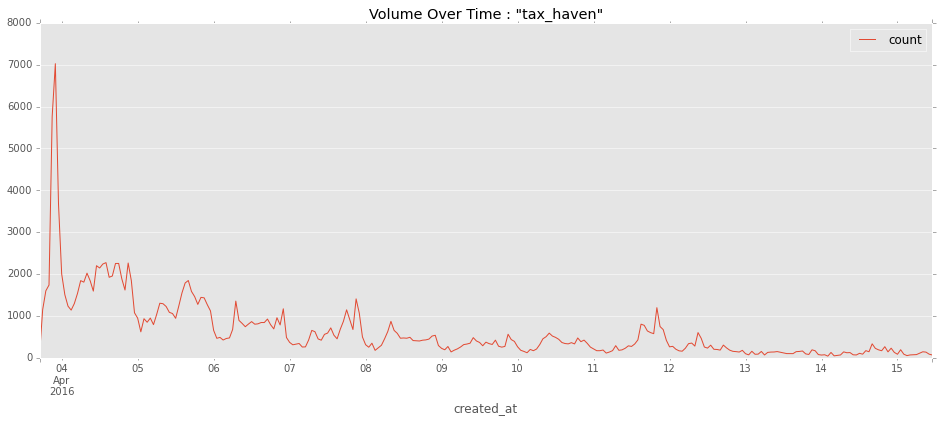

In [56]:
#get tweet counts on level day
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['id_str'].agg(['count'])
#plot tweets by day
d.plot(figsize=(16,6),
       legend=True, 
       title='Volume Over Time : "%s"' % keyword)
#get current figure, save
fig = plt.gcf()
fig.savefig('query_twitter_%s.png' % keyword)

In [57]:
#write new data to file
df.to_csv('data/final/query_%s_data.txt' % keyword, sep='\t', encoding='utf-8', header=True, index=False)